In [1]:
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

Define constants for the project

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TRAIN_DATA_PATH = "./R-jpg/"
img_size = 50
n_epochs = 10
batch_size = 8
log_batches = 30
gamma = 0.7
n_classes = 0
lr = 1.0
classes = []
for _, dirnames, filenames in os.walk(TRAIN_DATA_PATH):
    n_classes += len(dirnames)
    classes.append(dirnames)
classes = classes[0]
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize([img_size,img_size]),
    transforms.ToTensor()
    ])

Let's load the data

In [3]:
dataset = datasets.ImageFolder(TRAIN_DATA_PATH, transform=TRANSFORM_IMG)

Let's split the data for training and evaluation in the proportion of 80/20

In [4]:
train_data, test_data = random_split(dataset, [(int)(len(dataset) * 0.8), (int)(len(dataset) * 0.2) + 1])

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Let's look the data

In [6]:
def imshow(image, ax=None, title=None, normalize=False):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

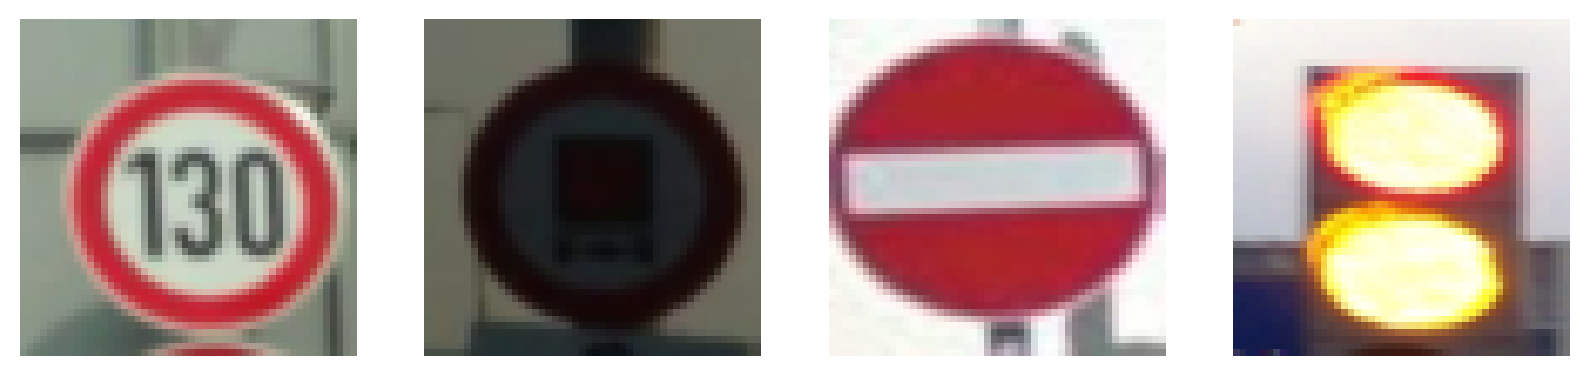

In [7]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

Try the simplest model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, img_size, 3, 1)
        self.conv2 = nn.Conv2d(img_size, img_size * 2, 3, 1)
        self.conv3 = nn.Conv2d(img_size * 2, img_size * 4, 3, 1)
        self.conv4 = nn.Conv2d(img_size * 4, img_size * 8, 3, 1)
        self.conv5 = nn.Conv2d(img_size * 8, img_size * 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320000, img_size * 32)
        self.fc2 = nn.Linear(img_size * 32, n_classes)
        self.batchNorm1 = nn.BatchNorm2d(img_size, 3, 1)
        self.batchNorm2 = nn.BatchNorm2d(img_size * 2, 3, 1)
        self.batchNorm3 = nn.BatchNorm2d(img_size * 4, 3, 1)
        self.batchNorm4 = nn.BatchNorm2d(img_size * 8, 3, 1)
        self.batchNorm5 = nn.BatchNorm2d(img_size * 16, 3, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchNorm4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.batchNorm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_batches == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/3809 (0%)]	Loss: 3.610381
Train Epoch: 1 [240/3809 (6%)]	Loss: 3.809891
Train Epoch: 1 [480/3809 (13%)]	Loss: 3.440275
Train Epoch: 1 [720/3809 (19%)]	Loss: 3.516773
Train Epoch: 1 [960/3809 (25%)]	Loss: 2.907478
Train Epoch: 1 [1200/3809 (31%)]	Loss: 3.305398
Train Epoch: 1 [1440/3809 (38%)]	Loss: 3.318842
Train Epoch: 1 [1680/3809 (44%)]	Loss: 2.984030
Train Epoch: 1 [1920/3809 (50%)]	Loss: 2.473719
Train Epoch: 1 [2160/3809 (57%)]	Loss: 2.135382
Train Epoch: 1 [2400/3809 (63%)]	Loss: 2.844265
Train Epoch: 1 [2640/3809 (69%)]	Loss: 2.850466
Train Epoch: 1 [2880/3809 (75%)]	Loss: 2.896463
Train Epoch: 1 [3120/3809 (82%)]	Loss: 2.379103
Train Epoch: 1 [3360/3809 (88%)]	Loss: 2.536894
Train Epoch: 1 [3600/3809 (94%)]	Loss: 2.059028

Test set: Average loss: 2.7597, Accuracy: 252/953 (26%)

Train Epoch: 2 [0/3809 (0%)]	Loss: 2.502998
Train Epoch: 2 [240/3809 (6%)]	Loss: 2.072447
Train Epoch: 2 [480/3809 (13%)]	Loss: 2.630014
Train Epoch: 2 [720/3809 (19%)]	Loss: 1.742401

Saving the trained model and eval 

In [11]:
def export_to_onnx(torch_model):
    x = torch.randn(1, 3, img_size, img_size, requires_grad=True)
    torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "./models/output_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])

In [12]:
PATH = './models/out_path.pth'
torch.save(model.state_dict(), PATH)

# Load model for eval 

In [13]:
model_eval = Net().to(device)
model_eval.load_state_dict(torch.load(PATH))
model_eval.eval()

Net(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(200, 400, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(400, 800, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320000, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=37, bias=True)
  (batchNorm1): BatchNorm2d(50, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(100, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(200, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(400, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm5): BatchNorm2d(800, eps=3, momentum=1, affine=True, track_running_stats=True)
)

You can use your path for the validation set (I took the same TRAIN_DATA_PATH with a random split)

In [14]:
TRAIN_DATA_PATH = TRAIN_DATA_PATH

In [15]:
dataset_eval = datasets.ImageFolder(TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
_, evalset_data = random_split(dataset, [(int)(len(dataset) * 0.9), (int)(len(dataset) * 0.1) + 1])
evens = list(range(0, (int)(len(evalset_data) * 0.05), 1))
evalset = torch.utils.data.Subset(evalset_data, evens)
evalset_loader = torch.utils.data.DataLoader(evalset, batch_size=1, shuffle=True)


In [16]:
from datetime import datetime
def eval_model(model_eval, evalset_loader):
    predicts = []
    show_imgs = 8
    avg_mcsec_time = 0
    count = 0
    fig, axes = plt.subplots(figsize=(10,4), ncols=show_imgs)
    counter_show = 0
    for batch_idx, (data, target) in enumerate(evalset_loader):
        start = datetime.now()
        predict = model_eval(data)
        end = datetime.now()
        mean_time = end - start
        avg_mcsec_time += mean_time.microseconds
        best_prob_indices = torch.argmax(predict)
        predicts.append(classes[best_prob_indices])
        count += 1
        if counter_show < show_imgs:
            ax = axes[counter_show]
            ax.set_xlabel(classes[best_prob_indices], fontsize=12)
            imshow(data.squeeze(), ax=ax, normalize=False)
            counter_show +=1
    avg_mcsec_time = avg_mcsec_time / count
    print("avg_mcsec_time: ", avg_mcsec_time, ", avg_msec_time: ", avg_mcsec_time / 1000)

avg_mcsec_time:  154963.34782608695 , avg_msec_time:  154.96334782608693


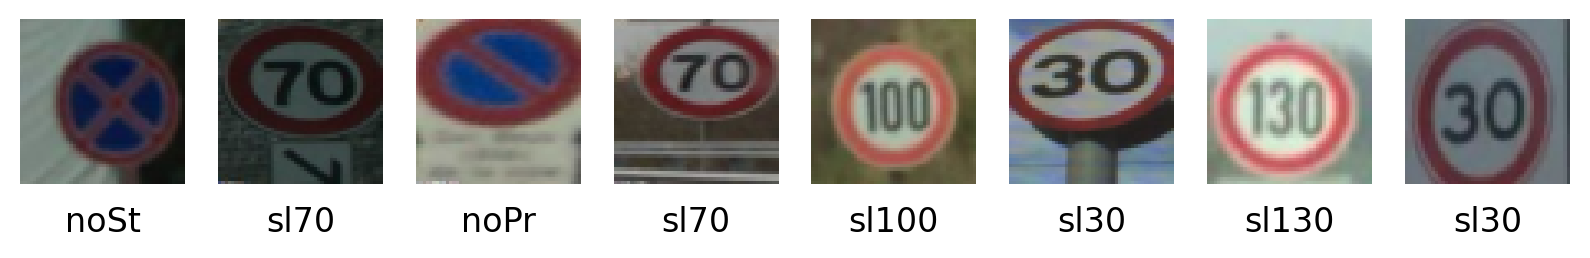

In [17]:
eval_model(model_eval, evalset_loader)

# Quantization (dynamic)

In [18]:
model_opt = Net().to(device)
model_opt.load_state_dict(torch.load(PATH))
model_opt.eval()

Net(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(200, 400, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(400, 800, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320000, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=37, bias=True)
  (batchNorm1): BatchNorm2d(50, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(100, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(200, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(400, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm5): BatchNorm2d(800, eps=3, momentum=1, affine=True, track_running_stats=True)
)

In [19]:
model_int8 = torch.quantization.quantize_dynamic(
    model_opt,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

avg_mcsec_time:  93987.91304347826 , avg_msec_time:  93.98791304347826


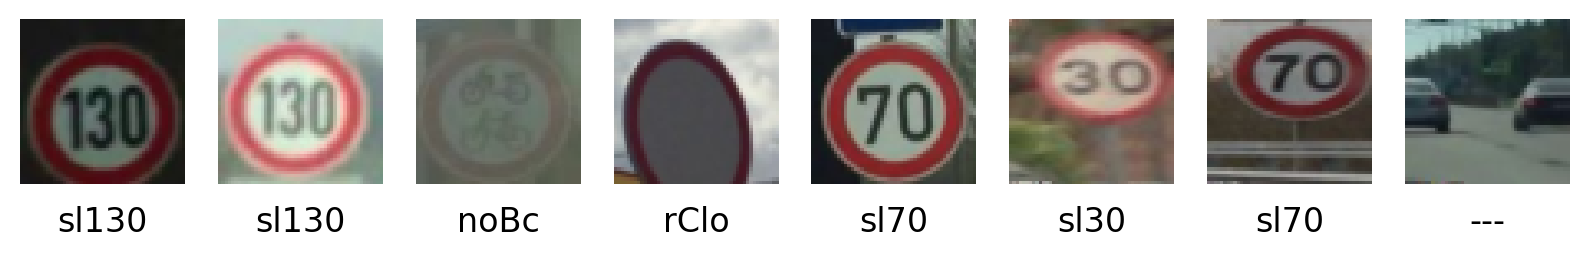

In [20]:
eval_model(model_int8, evalset_loader)

Example of traininng with quant preparing (Static quantization) - good working for ARM(qnnpack) 

In [21]:
class QuantNet(nn.Module):
    def __init__(self):
        super(QuantNet, self).__init__()
        self.conv1 = nn.Conv2d(3, img_size, 3, 1)
        self.conv2 = nn.Conv2d(img_size, img_size * 2, 3, 1)
        self.conv3 = nn.Conv2d(img_size * 2, img_size * 4, 3, 1)
        self.conv4 = nn.Conv2d(img_size * 4, img_size * 8, 3, 1)
        self.conv5 = nn.Conv2d(img_size * 8, img_size * 16, 3, 1)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320000, img_size * 32)
        self.fc2 = nn.Linear(img_size * 32, n_classes)
        self.batchNorm1 = nn.BatchNorm2d(img_size, 3, 1)
        self.batchNorm2 = nn.BatchNorm2d(img_size * 2, 3, 1)
        self.batchNorm3 = nn.BatchNorm2d(img_size * 4, 3, 1)
        self.batchNorm4 = nn.BatchNorm2d(img_size * 8, 3, 1)
        self.batchNorm5 = nn.BatchNorm2d(img_size * 16, 3, 1)

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.dequant(x)
        x = F.relu(x)
        x = self.quant(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.dequant(x)
        x = F.relu(x)
        x = self.quant(x)
        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = self.dequant(x)
        x = F.relu(x)
        x = self.quant(x)
        x = self.conv4(x)
        x = self.batchNorm4(x)
        x = self.dequant(x)
        x = F.relu(x)
        x = self.quant(x)
        x = self.conv5(x)
        x = self.batchNorm5(x)
        x = self.dequant(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [22]:
model_quantTrain = QuantNet().to(device)
optimizer = optim.Adadelta(model_quantTrain.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, n_epochs + 1):
    train(model_quantTrain, device, train_loader, optimizer, epoch)
    test(model_quantTrain, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/3809 (0%)]	Loss: 3.610276


In [ ]:
PATH_QUANT = './models/out_path_QUANT.pth'

In [ ]:
torch.save(model_quantTrain.state_dict(), PATH_QUANT)

In [ ]:
model_quantTr = QuantNet().to(device)
model_quantTr.load_state_dict(torch.load(PATH_QUANT))
model_quantTr.eval()

QuantNet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(200, 400, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(400, 800, kernel_size=(3, 3), stride=(1, 1))
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320000, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=37, bias=True)
  (batchNorm1): BatchNorm2d(50, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(100, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(200, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(400, eps=3, momentum=1, affine=True, track_running_stats=True)
  (batchNorm5): BatchNorm2d(800, eps=3, momentum=

avg_mcsec_time:  177448.86956521738 , avg_msec_time:  177.44886956521736


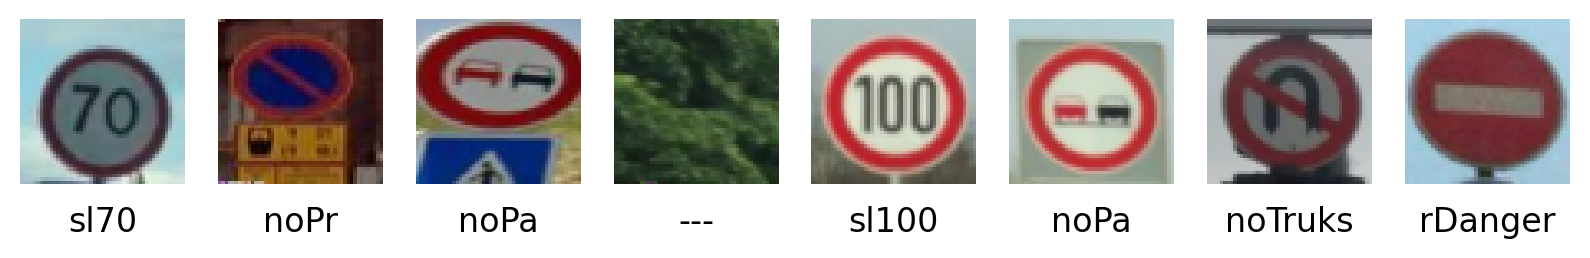

In [ ]:
eval_model(model_quantTr, evalset_loader)
export_to_onnx(model_quantTr)

In [ ]:
model_quantTr.qconfig = torch.quantization.get_default_qconfig('qnnpack')
modules_to_fuse = [['conv1', 'batchNorm1'], ['conv2', 'batchNorm2'], ['conv3', 'batchNorm3'], ['conv4', 'batchNorm4'], ['conv5', 'batchNorm5']]
model_fp32_fused = torch.quantization.fuse_modules(model_quantTr, modules_to_fuse)
model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)

for batch_idx, (data, target) in enumerate(evalset_loader):
    model_fp32_prepared(data)
    break

model_int8 = torch.quantization.convert(model_fp32_prepared)
model_int8.to(device)

QuantNet(
  (conv1): QuantizedConv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), scale=0.003980210982263088, zero_point=155)
  (conv2): QuantizedConv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), scale=0.0039664218202233315, zero_point=113)
  (conv3): QuantizedConv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), scale=0.005098343826830387, zero_point=108)
  (conv4): QuantizedConv2d(200, 400, kernel_size=(3, 3), stride=(1, 1), scale=0.007215843535959721, zero_point=117)
  (conv5): QuantizedConv2d(400, 800, kernel_size=(3, 3), stride=(1, 1), scale=0.008788255974650383, zero_point=89)
  (quant): Quantize(scale=tensor([0.0035]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (dropout1): QuantizedDropout(p=0.25, inplace=False)
  (dropout2): QuantizedDropout(p=0.5, inplace=False)
  (fc1): QuantizedLinear(in_features=320000, out_features=1600, scale=0.051966797560453415, zero_point=158, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=1600, out_featu

In [ ]:
eval_model(model_int8, evalset_loader) # Need Target platform! not working on CPU backend